In [1]:
import pandas as pd


ds_json = pd.read_json('data/lorawan_antwerp_2019_dataset.json')
gw_loc = pd.read_json('data/lorawan_antwerp_gateway_locations.json')

In [2]:
# Loading initial position coordinates form machine learning predictions
pos_pred_rssi = pd.read_csv('files/position_pred_RSSI.csv', index_col=0)
pos_pred_comb = pd.read_csv('files/position_pred_weather-comb.csv', index_col=0)

import pymap3d as pm 

ref_pos = {'lat0': 51.260644,
           'lon0': 4.370656,
           'h0': 0}

# pos_pred_rssi['x'], pos_pred_rssi['y'], pos_pred_rssi['z'] = pm.geodetic2ecef(lat=pos_pred_rssi['lat'], lon=pos_pred_rssi['lon'], alt=0)
# pos_pred_rssi['x_i'], pos_pred_rssi['y_i'], pos_pred_rssi['z_i'] = pm.geodetic2ecef(lat=pos_pred_rssi['pred_lat_rssi'], lon=pos_pred_rssi['pred_lon_rssi'], alt=0)

# pos_pred_comb['x'], pos_pred_comb['y'], pos_pred_comb['z'] = pm.geodetic2ecef(lat=pos_pred_comb['lat'], lon=pos_pred_comb['lon'], alt=0)
# pos_pred_comb['x_i'], pos_pred_comb['y_i'], pos_pred_comb['z_i'] = pm.geodetic2ecef(lat=pos_pred_comb['pred_lat_comb'], lon=pos_pred_comb['pred_lon_comb'], alt=0)


pos_pred_rssi['x'], pos_pred_rssi['y'], pos_pred_rssi['z'] = pm.geodetic2enu(lat=pos_pred_rssi['lat'], lon=pos_pred_rssi['lon'], h=0, **ref_pos)
pos_pred_rssi['x_i'], pos_pred_rssi['y_i'], pos_pred_rssi['z_i'] = pm.geodetic2enu(lat=pos_pred_rssi['pred_lat_rssi'], lon=pos_pred_rssi['pred_lon_rssi'], h=0, **ref_pos)

pos_pred_comb['x'], pos_pred_comb['y'], pos_pred_comb['z'] = pm.geodetic2enu(lat=pos_pred_comb['lat'], lon=pos_pred_comb['lon'], h=0, **ref_pos)
pos_pred_comb['x_i'], pos_pred_comb['y_i'], pos_pred_comb['z_i'] = pm.geodetic2enu(lat=pos_pred_comb['pred_lat_comb'], lon=pos_pred_comb['pred_lon_comb'], h=0, **ref_pos)


In [3]:
pos_pred_rssi.to_csv('files/pos_pred_rssi_enu.csv')
pos_pred_comb.to_csv('files/pos_pred_comb_enu.csv')

In [24]:
for idx, _ in pos_pred_comb.iterrows():
    r = pos_pred_comb.iloc[idx] 
    
    # pos_pred_comb.loc[row, 'new_col'] = row+1

In [5]:
from data_preprocess import get_gw_cord_tdoa

toa, gw_pos, tdoa, gw_lat_lon = get_gw_cord_tdoa(127217, ds_json, gw_loc, ref_pos)

Receiving gateways: ['080E00B9', 'FF01072B', 'FF01753E']
Time of arrivals: ['2019-01-18T08:06:49.058+01:00', '2019-01-18T08:06:49.942733360+01:00', '2019-01-18T08:06:49.942734458+01:00']
Gateway coordinates (enu): 
[[ 3.42950136e+03 -7.28623463e+03 -5.08444638e+00]
 [ 3.92258394e+03 -7.27064010e+03 -5.35025029e+00]
 [ 2.51986817e+03 -7.02576446e+03 -4.36865519e+00]]
Time difference of arrival: [[0, 1, -0.88473336], [0, 2, -0.8847344580000001], [1, 2, -1.0980000000000001e-06]]


In [8]:
# Initital position for estimation 
row = pos_pred_comb[pos_pred_comb['gw_ref']==127217]
init_pos = [row['x_i'].values[0], row['y_i'].values[0]]

In [9]:
import numpy as np

ts = np.asarray([pd.Timestamp(t) for t in toa])
measurements = np.c_[gw_pos[:, [0,2]], ts]

In [10]:
import numpy as np
import scipy.optimize as opt
import pymap3d as pm


# Speed of propagation (m/s)
speed = 3e8

# Function to generate the residuals for all hyperbolae
def functions(measurements, speeds):
    def fn(args):
        x, y = args[:2]  # Extract x and y coordinates from args
        residuals = []
        for i in range(len(measurements)):
            xi, yi, ti = measurements[i]
            x0 = measurements[0][0]
            y0 = measurements[0][1]
            # We use the pandas timestamp method in this case, 
            # because it is the only one that can handle precision upto nano second
            diff_seconds = (pd.Timestamp(ti).value - pd.Timestamp(measurements[0][2]).value) * 1e-9  # the values are converted to seconds
            di = diff_seconds * speeds[i]
            ai = np.sqrt((x - xi)**2 + (y - yi)**2) - np.sqrt((x - x0)**2 + (y - y0)**2) - abs(di)
            residuals.append(ai)
        return residuals
    return fn

# Function to generate the Jacobian matrix
def jacobian(measurements, speeds):
    def fn(args):
        x, y = args[:2]  # Extract x and y coordinates from args
        jac = []
        for i in range(len(measurements)):
            xi, yi, ti = measurements[i]
            x0 = measurements[0][0]
            y0 = measurements[0][1]
            # We use the pandas timestamp method in this case, 
            # because it is the only one that can handle precision upto nano second
            diff_seconds = (pd.Timestamp(ti).value - pd.Timestamp(measurements[0][2]).value) * 1e-9  # the values are converted to seconds
            di = diff_seconds * speeds[i]
            adx = (x - xi) / np.sqrt((x - xi)**2 + (y - yi)**2) - (x - x0) / np.sqrt((x - x0)**2 + (y - y0)**2)
            ady = (y - yi) / np.sqrt((x - xi)**2 + (y - yi)**2) - (y - y0) / np.sqrt((x - x0)**2 + (y - y0)**2)
            jac.append([adx, ady])
        return np.array(jac)
    return fn

# # Initial estimate for x and y
# xp = np.mean([x for x, y, t in measurements])
# yp = np.mean([y for x, y, t in measurements])

# Extract measurements for use in functions and jacobian
speeds = [speed] * len(measurements)

# Define functions and jacobian
F = functions(measurements, speeds)
J = jacobian(measurements, speeds)

# Perform least squares optimization
x, y = opt.leastsq(func=F, x0=init_pos, Dfun=J)

print(f"Optimized (x, y): ({x}, {y})")


Optimized (x, y): ([3429.75707706   -4.80682755], 1)


In [11]:
init_pos

[3341.8904595586846, -7405.904157410627]

In [12]:
lat_est, lon_est, _ = pm.enu2geodetic(e=x[0], n=x[1], u=0, **ref_pos)

In [13]:
pm.enu2geodetic(e=init_pos[0], n=init_pos[1], u=0, **ref_pos)


(51.1940659110033, 4.418462523900278, 5.175943740257093)

In [14]:
result = {
    'lat': [row['lat'].values[0], lat_est, row['pred_lat_comb'].values[0]] + [gw_lat_lon[i][0] for i in range(len(gw_lat_lon))],
    'lon': [row['lon'].values[0], lon_est, row['pred_lon_comb'].values[0]] + [gw_lat_lon[i][1] for i in range(len(gw_lat_lon))],
    'cat': ['Actual Pos', 'Estimated Pos', 'ML Predicted Pos'] + [f'GW Positions' for i in range(len(gw_lat_lon))]
}


In [15]:
result

{'lat': [51.1940650939941,
  51.26059048338313,
  51.194065856933584,
  51.195141,
  51.195278,
  51.197487],
 'lon': [4.4184684753418,
  4.419790294508029,
  4.418462562561034,
  4.419717,
  4.426771,
  4.406706],
 'cat': ['Actual Pos',
  'Estimated Pos',
  'ML Predicted Pos',
  'GW Positions',
  'GW Positions',
  'GW Positions']}

In [16]:
import plotly.express as px
import matplotlib.pyplot as plt 

def map_plot(resut_df, gw_ref):

    fig = px.scatter_mapbox(resut_df, 
                            lat='lat', 
                            lon='lon',
                            color='cat', 
                            zoom=11, 
                            height=800,
                            width=1400)
    # Update the marker size
    fig.update_traces(marker=dict(size=15))  # Adjust the size value as needed

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()
    fig.write_image(f"fig/map_plots/gw{gw_ref}.png")


In [17]:
map_plot(result, 127217)

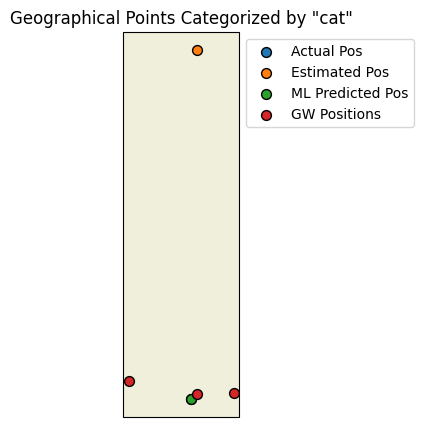

Map saved as categorized_map.png


: 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors

# Sample data structure
data = {
    'lat': [51.1940650939941, 51.26059048338313, 51.194065856933584, 51.195141, 51.195278, 51.197487],
    'lon': [4.4184684753418, 4.419790294508029, 4.418462562561034, 4.419717, 4.426771, 4.406706],
    'cat': ['Actual Pos', 'Estimated Pos', 'ML Predicted Pos', 'GW Positions', 'GW Positions', 'GW Positions']
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Create a plot with Cartopy
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Define a colormap for the 'cat' categories
categories = df['cat'].unique()
colors = plt.cm.tab10(range(len(categories)))  # Use a colormap with enough distinct colors
colormap = dict(zip(categories, colors))

# Plot each category with its respective color
for category in categories:
    subset = df[df['cat'] == category]
    ax.scatter(subset['lon'], subset['lat'], color=colormap[category], s=50, edgecolor='k', label=category, transform=ccrs.PlateCarree())

# Add a legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add title and labels
plt.title('Geographical Points Categorized by "cat"')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot to a file
output_file = 'categorized_map.png'
plt.savefig(output_file, bbox_inches='tight')
plt.show()

print(f"Map saved as {output_file}")
